# 1. Importing Libraries and Data

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

## 1.1. Libraries

In [2]:
# Most common libraries for functionality
import pandas as pd
import os
os.chdir(os.path.dirname(os.getcwd()))
import numpy as np
from datetime import datetime, date
from dateutil import relativedelta
import matplotlib.pyplot as plt
import copy
%load_ext autoreload
%autoreload 2
import pickle as pkl

In [3]:
# TSA Libraries
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from tbats import TBATS, BATS
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import itertools
from fbprophet import Prophet


ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [4]:
# Own libraries 
from src.data import preprocessing
from src.analysis import forecasting

In [5]:
# Additional forecasting libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
import holidays

## 1.2. Reading the data

In [6]:
# Change the path to the following:
DATA_PATH = './data/raw/'
os.listdir(DATA_PATH)

gas_demand = pd.read_excel(DATA_PATH + os.listdir(DATA_PATH)[6])

['consumption-dk-areas_2018_hourly.xls',
 'Data1.xlsx',
 'Demand.xls',
 'Demand.xlsx',
 'elspot-prices_2018_hourly_dkk.xls',
 'ExitZoneAllocation.xls',
 'ExitZoneAllocation.xlsx',
 'Mappe1.xlsx',
 'sunspots.csv']

Data will be cleaned and explored for further analysis, just so that it can be used better in the modelling.

In [7]:
# As there are multiple sources of data for demand (multiple 'exit zones'), the data has to be aggregated (summed)
gas_demand = gas_demand.groupby(['Time'])['Data'].sum()


In [8]:
# Cleaning the data, assigning time to index for easier further analysis
gas_demand.index = pd.to_datetime(gas_demand.index, format='%d-%m-%Y')
gas_demand.index = pd.DatetimeIndex(gas_demand.index.values, freq=gas_demand.index.inferred_freq)
gas_demand = gas_demand.sort_index()

In [9]:
# Changing the numbers to MWh for clarity
gas_demand = gas_demand/1000


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# 2. Prophet

## 2.1. EDA

In [10]:
gas_demand.head()

2012-01-01    3613.082
2012-01-02    4787.492
2012-01-03    5091.137
2012-01-04    5230.142
2012-01-05    5403.952
Name: Data, dtype: float64

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Daily gas demand in Denmark [MWh]')

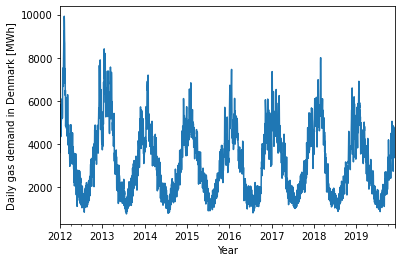

In [11]:
gas_demand.plot()
plt.xlabel('Year')
plt.ylabel('Daily gas demand in Denmark [MWh]')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Daily gas demand in Denmark [MWh]')

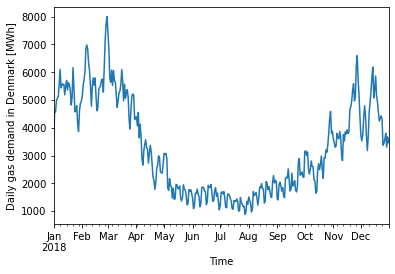

In [12]:
gas_demand.loc['2018'].plot()
plt.xlabel('Time')
plt.ylabel('Daily gas demand in Denmark [MWh]')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Time differenced daily gas demand in Denmark [MWh]')

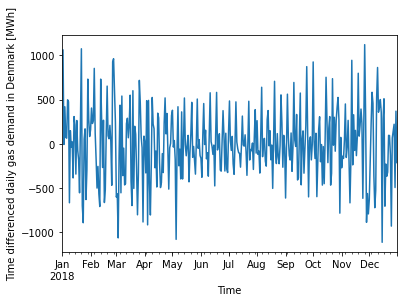

In [13]:
gas_demand.loc['2018'].diff().plot()
plt.xlabel('Time')
plt.ylabel('Time differenced daily gas demand in Denmark [MWh]')

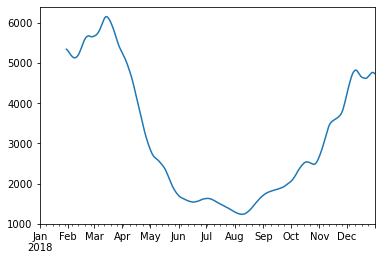

In [14]:
gas_demand.loc['2018'].rolling(30, win_type='triang').mean().plot()

In [15]:
# Replace with src.forecasting.mean...
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [16]:
# Replace with src.forecasting.plot...
def plot_mean_and_CI(mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    plt.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=.5)
    # plot the mean on top
    plt.plot(mean, color_mean)

## 2.2. Holidays

In [17]:
dk_holidays = holidays.Denmark()

In [18]:
holidays_analysed = []
for year in range(2012,2020):
    for date, name in sorted(holidays.DK(years=year).items()):
        holidays_analysed.append((date, name))

In [19]:
holidays_analysed = pd.DataFrame(holidays_analysed)
holidays_analysed.columns = ['ds', 'holiday']
holidays_analysed

,ds,holiday
0,2012-01-01,Nytårsdag
1,2012-04-01,Palmesøndag
2,2012-04-05,Skærtorsdag
3,2012-04-06,Langfredag
4,2012-04-08,Påskedag
...,...,...
91,2019-05-30,Kristi himmelfartsdag
92,2019-06-09,Pinsedag
93,2019-06-10,Anden pinsedag
94,2019-12-25,Juledag


In [20]:
holidays_analysed.holiday.unique()

array(['Nytårsdag', 'Palmesøndag', 'Skærtorsdag', 'Langfredag',
       'Påskedag', 'Anden påskedag', 'Store bededag',
       'Kristi himmelfartsdag', 'Pinsedag', 'Anden pinsedag', 'Juledag',
       'Anden juledag'], dtype=object)

## 2.3. Preprocessing

In [21]:
# Prophet needs preprocessing - there have to be 2 columns, 'ds' and 'y'
gas_demand_prophet = pd.DataFrame(gas_demand)
gas_demand_prophet['Time'] = gas_demand_prophet.index
gas_demand_prophet = gas_demand_prophet.reset_index()
gas_demand_prophet = gas_demand_prophet.loc[:,['Data','Time']]
gas_demand_prophet.columns = ['y', 'ds']
gas_demand_prophet.head()

,y,ds
0,3613.082,2012-01-01
1,4787.492,2012-01-02
2,5091.137,2012-01-03
3,5230.142,2012-01-04
4,5403.952,2012-01-05


In [22]:
data_since = '2012-01-01'
data_till = '2016-06-30'
forecasting_since = '2016-07-01'
forecasting_till = '2017-04-30'
two_years_before = '2014-07-01'

In [23]:
# Creating training dataset
train_df = gas_demand_prophet[(gas_demand_prophet['ds'] >= data_since) & (gas_demand_prophet['ds'] <= data_till)]
test_dt = gas_demand_prophet[(gas_demand_prophet['ds'] >= forecasting_since) & (gas_demand_prophet['ds'] <= forecasting_till)]


## 2.4. Modelling

In [24]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, growth='linear', holidays=holidays_analysed)
m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


In [25]:
model_fit = m.make_future_dataframe(periods = ((pd.to_datetime(forecasting_till) - pd.to_datetime(forecasting_since)).days + 1))
test_y = m.predict(model_fit)

In [26]:
y_true = gas_demand.loc[forecasting_since:forecasting_till]

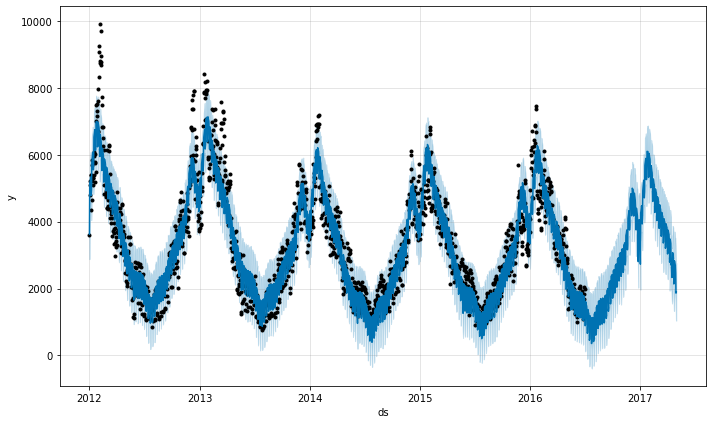

Text(17.200000000000003, 0.5, 'Average daily demand [MWh]')

Text(0.5, 17.200000000000003, 'Time')

(735415.0, 736449.0)

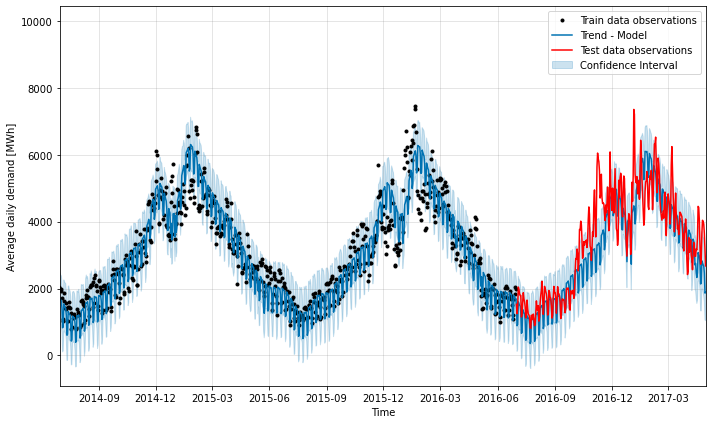

In [27]:
m.plot(test_y)
plt.plot(y_true, color = 'red')
plt.ylabel('Average daily demand [MWh]')
plt.xlabel('Time')
plt.xlim((pd.to_datetime(two_years_before), pd.to_datetime(forecasting_till)))
plt.legend(['Train data observations', 'Trend - Model', 'Test data observations', 'Confidence Interval'])


In [28]:
print('MAE =', mean_absolute_error(y_true, test_y['yhat'][(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)]))
print('MAPE =', forecasting.mean_absolute_percentage_error(y_true, test_y['yhat'][(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)]))
print('RMSE =', mean_squared_error(y_true, test_y['yhat'][(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)], squared = False))


MAE = 558.0027005439098
MAPE = 0.16757617690471568
RMSE = 756.6033370444768


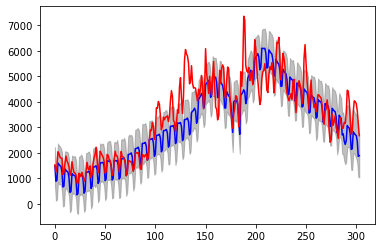

In [30]:
y_pred = test_y[(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)].reset_index()
forecasting.plot_mean_and_CI(y_pred['yhat'], y_pred['yhat_lower'], y_pred['yhat_upper'], color_mean = 'blue', color_shading = 'grey')
plt.plot(gas_demand.loc[forecasting_since:forecasting_till].values, color = 'red')


# GBM

This part of analysis will analyse GBM algorithms, mostly using sklearn API.
This contains ADABoost, GradientBoostingClassifier and HistGradientBoost (which is alternative for LightGBM).

# Feature Engineering

In [31]:
# Changing series to dataframe, as it will have multiple variables
gas_demand_gbm = pd.DataFrame(gas_demand)


In [32]:
# Reconstruction of the dataframe
gas_demand_gbm['Time'] = gas_demand_gbm.index



In [33]:
# Adding new variables - time
gas_demand_gbm['weekday'] = gas_demand_gbm['Time'].dt.weekday
gas_demand_gbm['month'] = gas_demand_gbm['Time'].dt.month
gas_demand_gbm['year'] = gas_demand_gbm['Time'].dt.year
gas_demand_gbm['day'] = gas_demand_gbm['Time'].dt.day


In [34]:
# Adding holidays in one column with their names
gas_demand_gbm = pd.merge(gas_demand_gbm, holidays_analysed, how = 'left', left_on = gas_demand_gbm.index, right_on = holidays_analysed.ds)
gas_demand_gbm = gas_demand_gbm.drop(['ds'], axis = 1)

In [35]:
gas_demand_gbm

,key_0,Data,Time,weekday,month,year,day,holiday
0,2012-01-01,3613.082,2012-01-01,6,1,2012,1,Nytårsdag
1,2012-01-02,4787.492,2012-01-02,0,1,2012,2,NaN
2,2012-01-03,5091.137,2012-01-03,1,1,2012,3,NaN
3,2012-01-04,5230.142,2012-01-04,2,1,2012,4,NaN
4,2012-01-05,5403.952,2012-01-05,3,1,2012,5,NaN
...,...,...,...,...,...,...,...,...
2887,2019-11-27,4114.640,2019-11-27,2,11,2019,27,NaN
2888,2019-11-28,4057.903,2019-11-28,3,11,2019,28,NaN
2889,2019-11-29,4680.526,2019-11-29,4,11,2019,29,NaN
2890,2019-11-30,4655.325,2019-11-30,5,11,2019,30,NaN


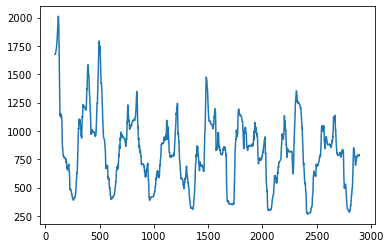

In [36]:
# Add logs and rolling means and stds
gas_demand_gbm.loc[:,'Data'].rolling(90, win_type='triang').std().plot()

In [37]:
# TBC...

# Appendix - Additional analysis

## Analysis of weekly and yearly seasonalities

In [38]:
weekly_gas_demand = pd.DataFrame(gas_demand)
weekly_gas_demand['Time'] = weekly_gas_demand.index

In [39]:
gas_demand.tail()

2019-11-27    4114.640
2019-11-28    4057.903
2019-11-29    4680.526
2019-11-30    4655.325
2019-12-01    4771.638
Name: Data, dtype: float64

In [40]:
weekly_gas_demand.tail()

,Data,Time
2019-11-27,4114.640,2019-11-27
2019-11-28,4057.903,2019-11-28
2019-11-29,4680.526,2019-11-29
2019-11-30,4655.325,2019-11-30
2019-12-01,4771.638,2019-12-01


In [41]:
weekly_gas_demand = weekly_gas_demand.resample('W-Mon', on='Time')['Data'].mean()

In [42]:
weekly_gas_demand.loc['2013':'2018']

Time
2013-01-07    4398.350000
2013-01-14    6243.061429
2013-01-21    7730.429571
2013-01-28    7300.678857
2013-02-04    5481.476286
                 ...     
2018-12-03    4686.743286
2018-12-10    4098.324857
2018-12-17    5508.408857
2018-12-24    4565.772714
2018-12-31    3516.346429
Freq: W-MON, Name: Data, Length: 313, dtype: float64

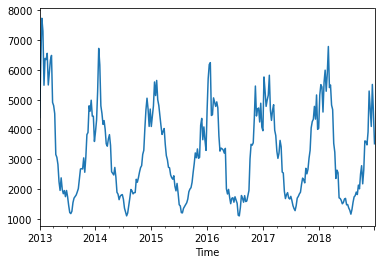

In [43]:
weekly_gas_demand.loc['2013':'2018'].plot()

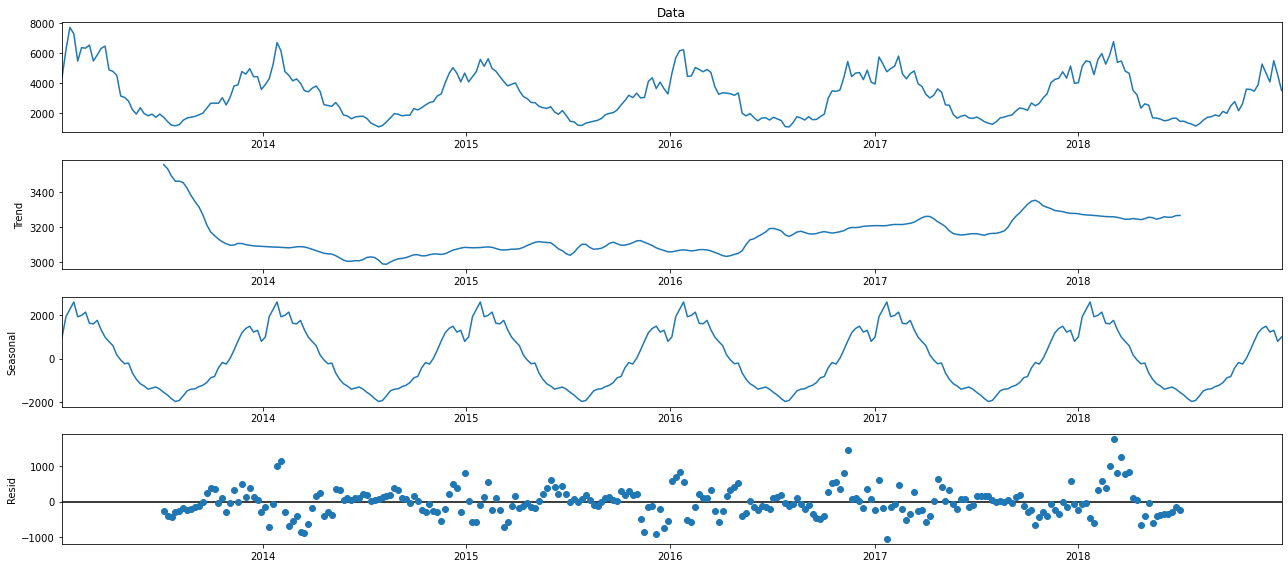

In [44]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition_yearly = sm.tsa.seasonal_decompose(weekly_gas_demand.loc['2013':'2018'], model='additive')
fig = decomposition_yearly.plot()
plt.show()

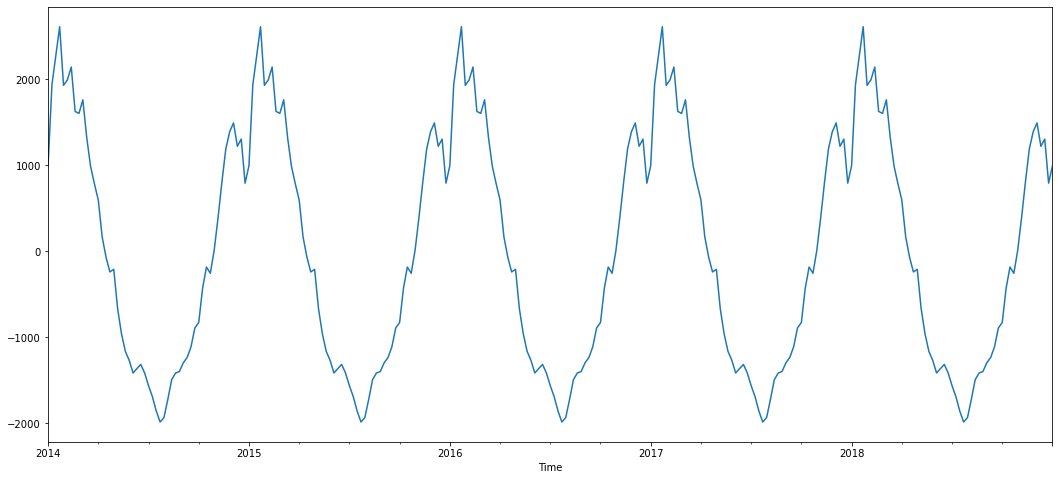

In [45]:
decomposition_yearly.seasonal.loc['2014':'2018'].plot()

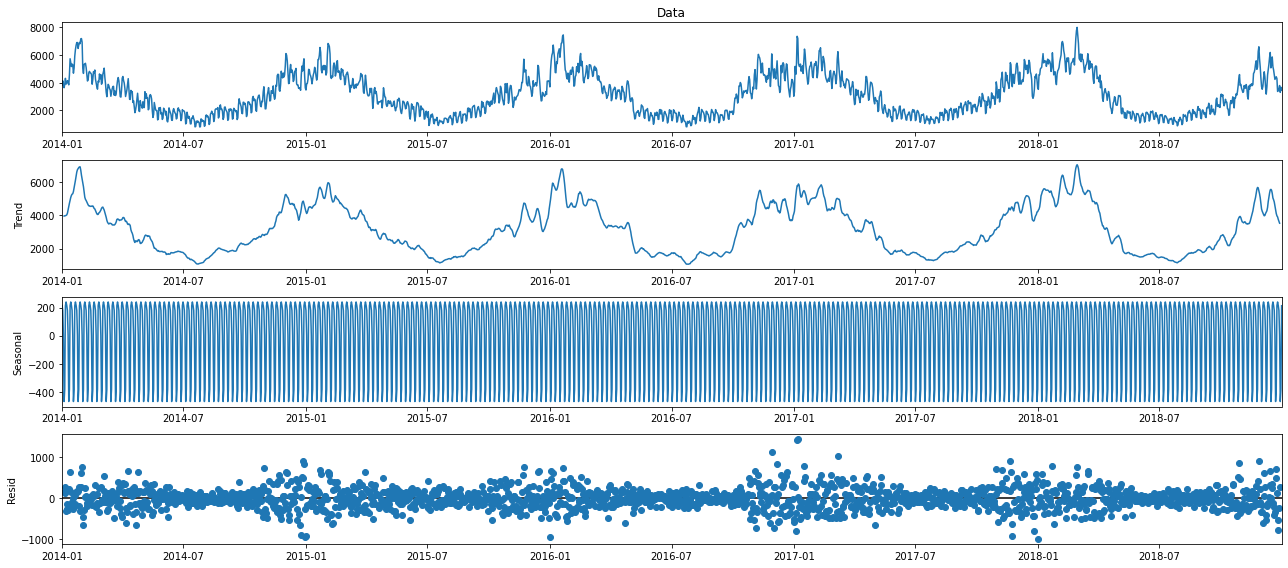

In [46]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition_weekly = sm.tsa.seasonal_decompose(gas_demand.loc['2014':'2018'], model='additive')
fig = decomposition_weekly.plot()
plt.show()

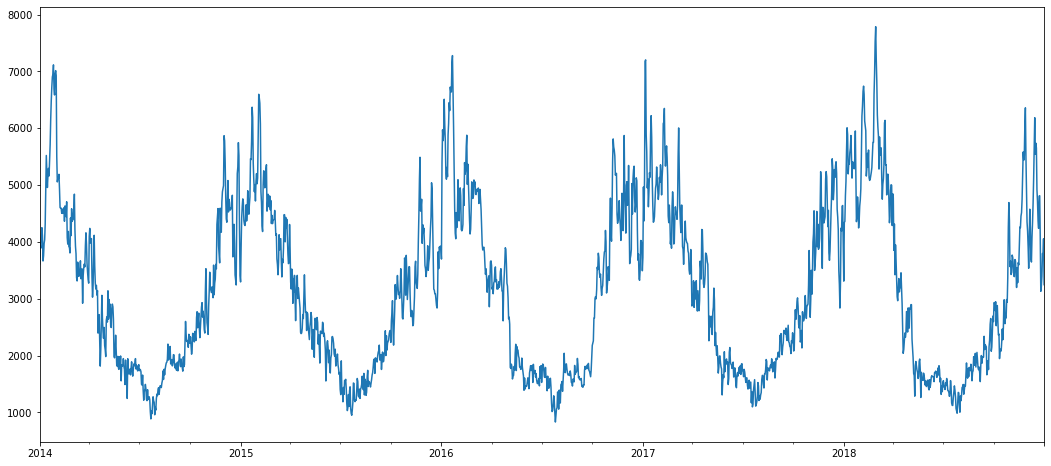

In [47]:
(decomposition_weekly.observed - decomposition_weekly.seasonal).plot()

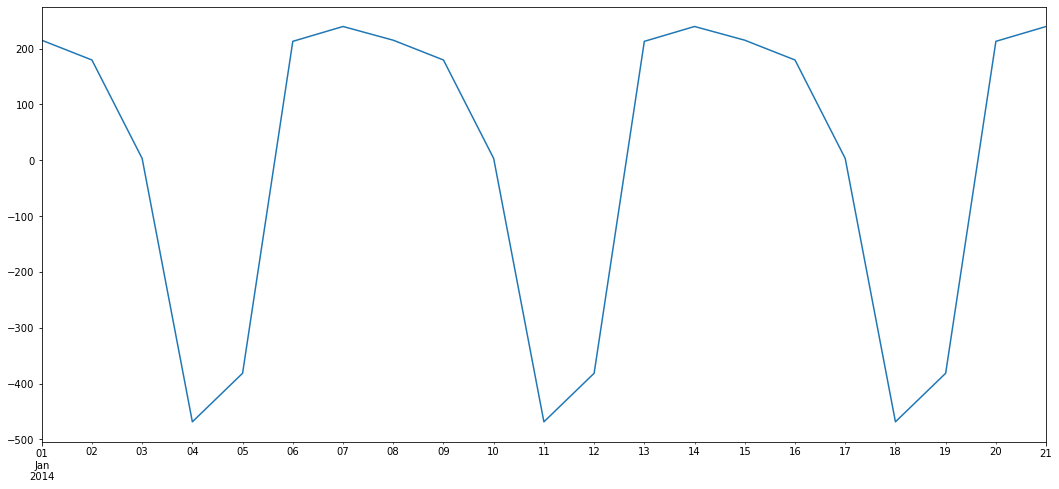

In [48]:
decomposition_weekly.seasonal.iloc[:21].plot()

In [49]:
decomposition_weekly.seasonal

2014-01-01    214.905193
2014-01-02    179.481543
2014-01-03      3.167170
2014-01-04   -468.442636
2014-01-05   -381.468053
                 ...    
2018-12-27    179.481543
2018-12-28      3.167170
2018-12-29   -468.442636
2018-12-30   -381.468053
2018-12-31    212.879320
Name: seasonal, Length: 1826, dtype: float64

In [50]:
decomposition_yearly.seasonal

Time
2013-01-07     996.168589
2013-01-14    1938.334235
2013-01-21    2274.055555
2013-01-28    2613.934587
2013-02-04    1931.464884
                 ...     
2018-12-03    1494.267044
2018-12-10    1222.420932
2018-12-17    1306.369166
2018-12-24     793.463877
2018-12-31     996.168589
Freq: W-MON, Name: seasonal, Length: 313, dtype: float64

# SARIMAX
Using SARIMAX just to show methodology, knowing that any kind of metrics used to represent accuracy is going to have super high values.

Also, to provide code for future potential analysis.

In [61]:
# fit model
model = sm.tsa.statespace.SARIMAX(gas_demand[data_since:data_till],
                                  order=(3,1,3),
                                  seasonal_order=(2,2,3,7),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
model_fit = model.fit(disp=0)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


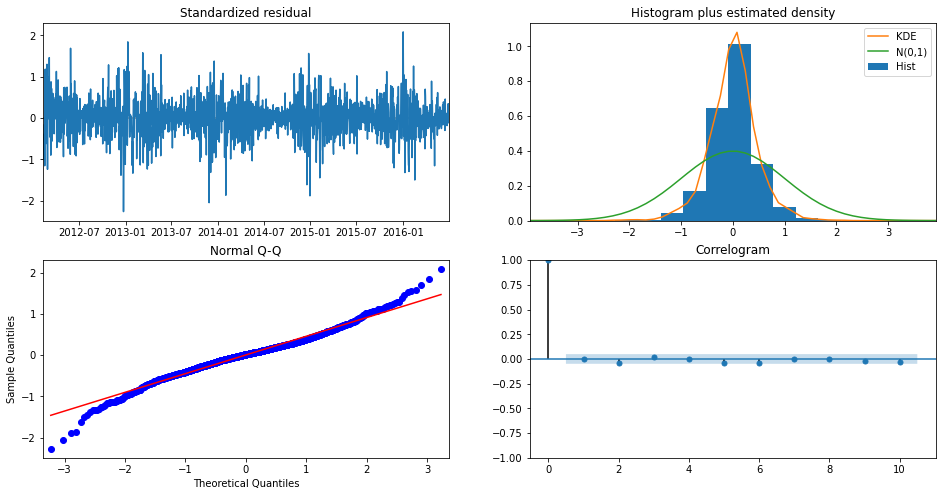

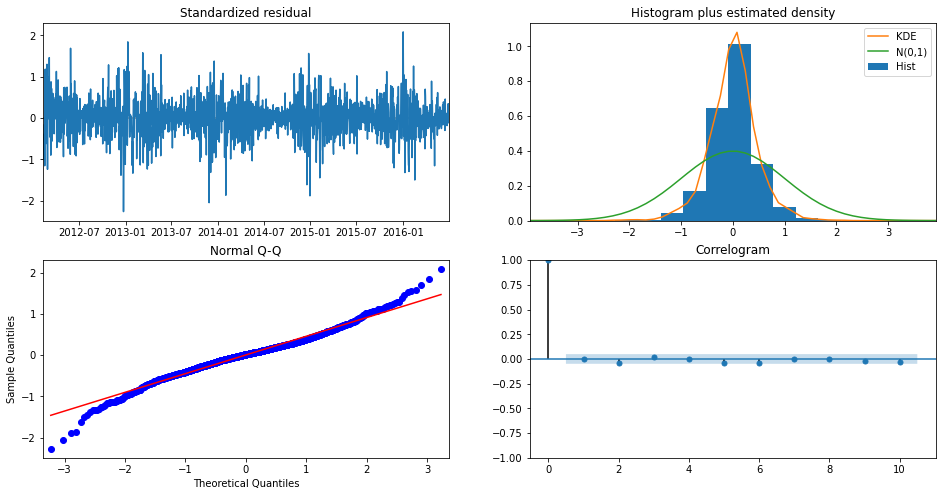

In [62]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

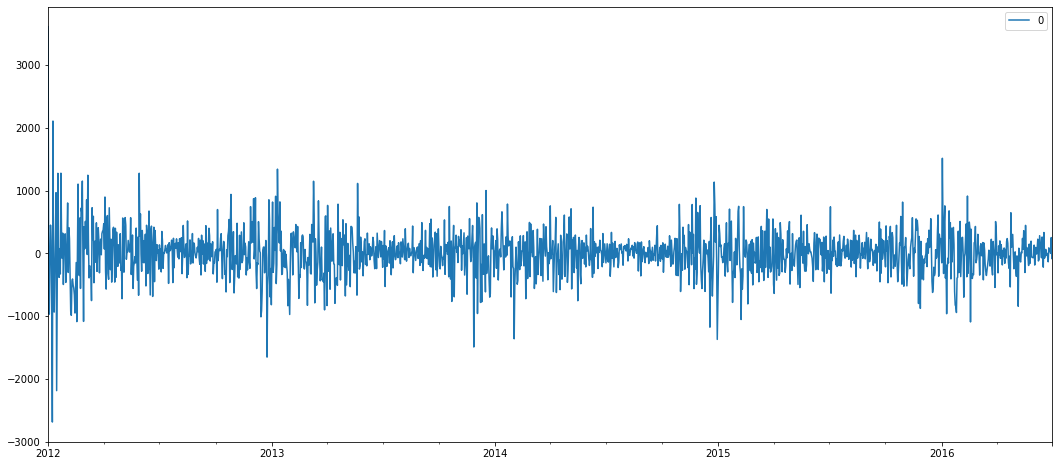

In [63]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

                 0
count  1643.000000
mean      4.217530
std     367.857339
min   -2686.951095
25%    -185.652112
50%      14.201761
75%     189.913150
max    3613.082000


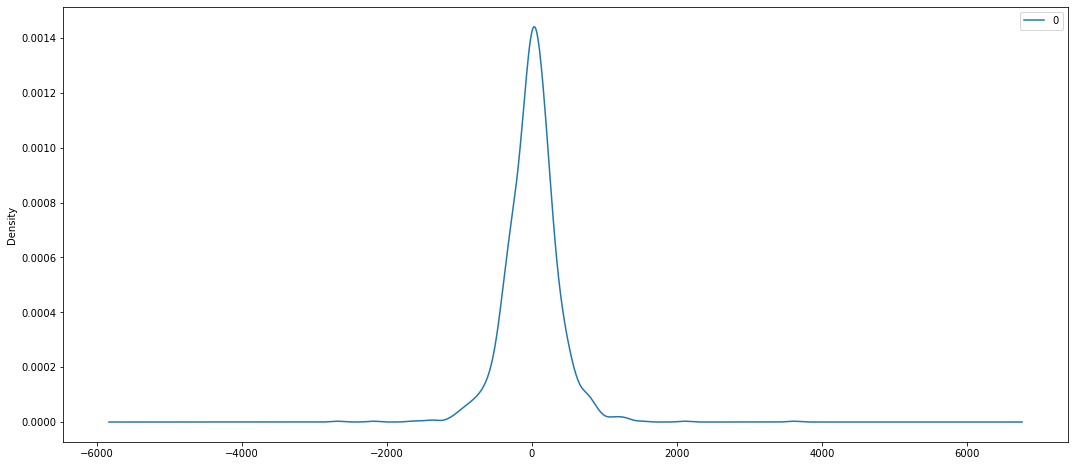

In [64]:
# density plot of the residual error values
residuals.plot(kind='kde')
print(residuals.describe())

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Gas prices')

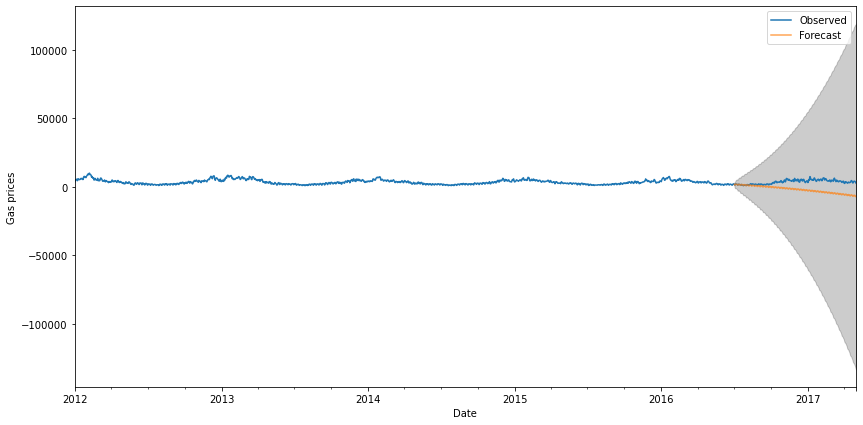

In [66]:
pred = model_fit.get_prediction(start=forecasting_since, end=forecasting_till, dynamic=False)
pred_ci = pred.conf_int()
ax = gas_demand[data_since:forecasting_till].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Gas prices')
plt.legend()
plt.show()

In [69]:
y_forecasted = pred.predicted_mean
y_truth = gas_demand[forecasting_since:forecasting_till]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 42717814.01
The Root Mean Squared Error of our forecasts is 6535.89
